## Dataset

El set de datos seleccionado consta de las construcciones en Costa Rica realizadas por el sector privado extraido por medio de una encuesta anual que se realiza por el Instituo Nacional de Estadísticas y Censo (INEC) desde el año 2002 hasta el año 2018 con excepción del año 2008 que no se realizó esta encuesta.

Nombre | Etiqueta | Pregunta | Tipo de dato
--- | --- | --- | ---
anoper | Año del permiso | Fecha (año): | Numérico
num_obras | Número de obras | Indique Nº de obras:  | Numérico
arecon | Area de construcción | Área de construcción (metros cuadrados m2)  | Numérico
valobr | Valor de la obra | Valor de la obra (Colones):  | Numérico
claper | Clase del permiso | Permiso para:  | Categórico
claobr | Clase de la obra | Clase de obra: | Categórico
numpis | Número de pisos | Número de pisos | Numérico
numviv | Número de viviendas | Nº de viviendas (incluye apartamentos). | Numérico
numapo | Número de aposentos | Nº total de aposentos | Numérico
numdor | Número de dormitorios | Nº de aposentos usados como dormitorios | Numérico
matpis | Material de piso | Materiales predominantes. Pisos: | Categórico
matpar | Material de pared | Materiales predominantes. Paredes: | Categórico
mattec | Material de techo | Materiales predominantes. Techos: | Categórico
usoobr | Uso de la obra | La construcción de la obra será para: | Categórico
financ | Financiamiento | Financiamiento (Marque únicamente el de mayor aporte): | Categórico
cod_provincia | Codigo Provincia | Codigo Provincia | Categórico
provincia | Nombre Provincia | Nombre Provincia | Texto (se ingora)
id_canton | Codigo Canton | Codigo Canton | Categórico (se ignora)
canton | Nombre Canton | Nombre Canton | Texto (se ignora)
id_region | Codigo Region | Codigo Region | Categórico
cat | Categoría | **Valor de predicción** | Categórico binario. 


Todos estas columnas menos la columna *id_region* son tomados de la encuesta realizada por el INEC. La columna *id_region* es calculada utilizando la siguente [referencia](https://es.wikipedia.org/wiki/Regiones_socioecon%C3%B3micas_de_Costa_Rica).


In [1]:
!rm -rf coco
!git clone --single-branch --branch presentacion https://github.com/mariobarque/costarica-construction.git coco

Cloning into 'coco'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 438 (delta 24), reused 27 (delta 13), pack-reused 397
Receiving objects: 100% (438/438), 210.20 MiB | 30.96 MiB/s, done.
Resolving deltas: 100% (232/232), done.
Checking out files: 100% (55/55), done.


In [0]:
from coco import dataset
from coco import lstsq_model
from coco import utilities
from coco import tree
from coco import model
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve  
from sklearn.metrics import roc_auc_score  
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

prediction_variable = 'cat'

# Se obtienen los datos
df = dataset.get_data_for_model('coco/data/construction-data-processed.csv', N=10000)

# Se separan entre entrenamiento y pruebas
train, test = train_test_split(df, test_size=0.1)


## Minimos Cuadrados

Top 5 columnas más importantes:
               Column    Weight
30           matpis_8  0.542472
37          matpis_15  0.461624
62           matpar_3  0.444115
138   arecon_cat_1000  0.346383
139  arecon_cat_1000+  0.312908
AUC:  0.9571310255425389
Error:  9.317006351730678


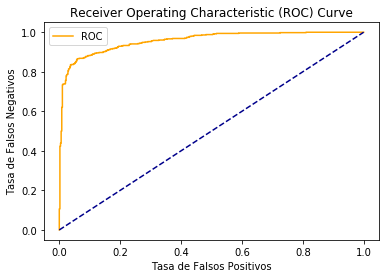

In [3]:
# Se entrenan los datos con el modelo
weights, errors = model.train(train, 9, lstsq_model.train, prediction_variable)

# Las 5 columnas más importantes con sus pesos
print('Top 5 columnas más importantes:')
print(utilities.get_top_most_significant_variables(train, weights, 5))

# Se prueba el modelo
error_lstsqr, prediction_lstsqr = model.test(test, weights, prediction_variable)

# Se grafica la curva ROC
utilities.plot_roc_curve(test[prediction_variable], prediction_lstsqr, error_lstsqr)

## Regresión Logística

Top 5 columnas más importantes:
              Column      Weight
138  arecon_cat_1000  830.140930
142    numpis_cat_1+  282.703491
149     numapo_cat_4  208.033188
44         matpis_22  204.741409
15       anoper_2018  197.947540
AUC:  0.9560787561615773
Error:  31086.725043271927


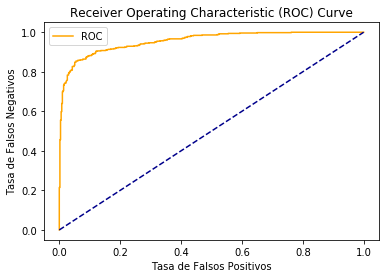

In [4]:
from coco import logisticregression_model


# Se entrenan los datos con el modelo
weights, errors = model.train(train, 9, logisticregression_model.train, prediction_variable)

# Las 5 columnas más importantes con sus pesos
print('Top 5 columnas más importantes:')
print(utilities.get_top_most_significant_variables(train, weights, 5))

# Se prueba el modelo
error_logistic, prediction_logistic = model.test(test, weights, prediction_variable)

# Se grafica la curva ROC
utilities.plot_roc_curve(test[prediction_variable], prediction_logistic, error_logistic)

## Perceptrón Multicapa

Top 5 columnas más importantes:
              Column      Weight
138  arecon_cat_1000  830.140930
142    numpis_cat_1+  282.703491
149     numapo_cat_4  208.033188
44         matpis_22  204.741409
15       anoper_2018  197.947540


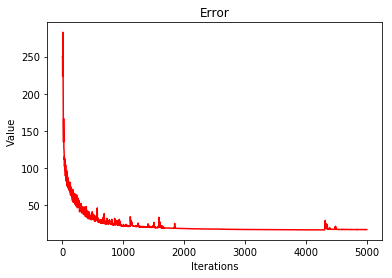

AUC:  0.879983275718584
Error:  543.4822319700455


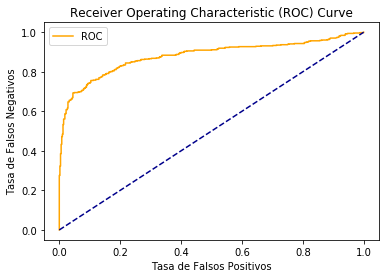

In [5]:
from coco import perceptron_multilayer_model


# Se entrenan los datos con el modelo
errors, wo, ws = model.train_network(train, 9, perceptron_multilayer_model.train, 12, prediction_variable, epochs = 5000, alpha = 1)

# Las 5 columnas más importantes con sus pesos
print('Top 5 columnas más importantes:')
print(utilities.get_top_most_significant_variables(train, weights, 5))

# Se grafica el error promedio de todas los K
utilities.plot_error(errors)

# Se prueba el modelo
error_perceptron, prediction_perceptron = model.test_network(test, perceptron_multilayer_model.forward_pass_test, wo, ws, prediction_variable)

# Se grafica la curva ROC
utilities.plot_roc_curve(test[prediction_variable], prediction_perceptron, error_perceptron)

## Random Forest

{'training_size': 2, 'correctness': 0.5}
{'training_size': 4, 'correctness': 0.5777777777777777}
{'training_size': 6, 'correctness': 0.5388888888888889}
{'training_size': 8, 'correctness': 0.5277777777777778}
{'training_size': 10, 'correctness': 0.75}
{'training_size': 12, 'correctness': 0.7222222222222222}
{'training_size': 14, 'correctness': 0.7555555555555555}
{'training_size': 16, 'correctness': 0.6888888888888889}
{'training_size': 18, 'correctness': 0.6055555555555555}
{'training_size': 20, 'correctness': 0.6166666666666667}
{'training_size': 22, 'correctness': 0.65}
Root: id_region_5
Root: id_region_5
Root: numdor_cat_4


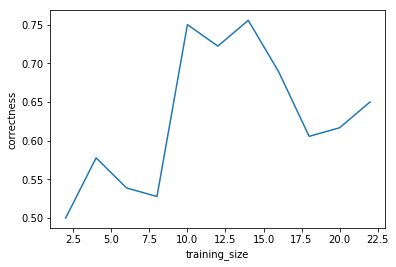

In [6]:
# Limitarlo a mil samples
df_for_rf = df.head(1000)
# Se separan entre entrenamiento y pruebas
train_for_rf, test_for_rf = train_test_split(df_for_rf, test_size=0.1)


rf = tree.RandomForest(train_for_rf, 'cat', col_groups=1, 
                                              row_groups=3, 
                                              train_test_ratio=0.2, 
                                              impurity_function='entropy', # gini or entropy
                                              algorithm='id3') # id3 or cart

import seaborn as sns
import matplotlib.pyplot as plt


# Se evalua 
evaluation = rf.evaluate_forest(increase=2, max_size=20)
sns.lineplot(x="training_size", y="correctness", data=evaluation)

for current_tree in rf.trees:
  print("Root:", current_tree.feature)

In [19]:
from sklearn.tree import DecisionTreeClassifier
model_sklearn = DecisionTreeClassifier(criterion='entropy')

train_sklearn, test_sklearn = train_test_split(df, test_size=0.1)


x_sklearn = df_sklearn.drop('cat', axis=1)
y_sklearn = df_sklearn['cat'].values
model_sklearn.fit(x_sklearn, y_sklearn)

test_x_sklearn = test_sklearn.drop('cat', axis=1)
test_y_sklearn = test_sklearn['cat'].values

test_predict_sklearn = model_sklearn.predict(test_x_sklearn)

corrects = 0
for i in range(len(test_y_sklearn)):
  if test_y_sklearn[i] == test_predict_sklearn[i]:
    corrects += 1
    
print('Prediction acuracy:', float(corrects)/float(len(test_y_sklearn)))

Prediction acuracy: 0.867


## Kmeans



In [8]:
from coco import kmeans

df_for_kmeans = df.head(1000)
# Se separan entre entrenamiento y pruebas
train_for_kmeans, test_for_kmeans = train_test_split(df_for_kmeans, test_size=0.2)

kmeans_list = kmeans.train_multiple(train, 3, max_iter=5)

print('Empezando la prueba:')
correctness = kmeans.correctness_with_multiple_kmeans(test, kmeans_list)
print('Correctness: ', correctness)

Empezando la prueba:
Correctness:  0.772
